In [332]:
import pandas as pd
import numpy as np
import plotly.express as px

In [333]:
smiley = pd.read_csv('smiley.csv', index_col = 0)
smiley.columns = ['x', 'y', 'classes']

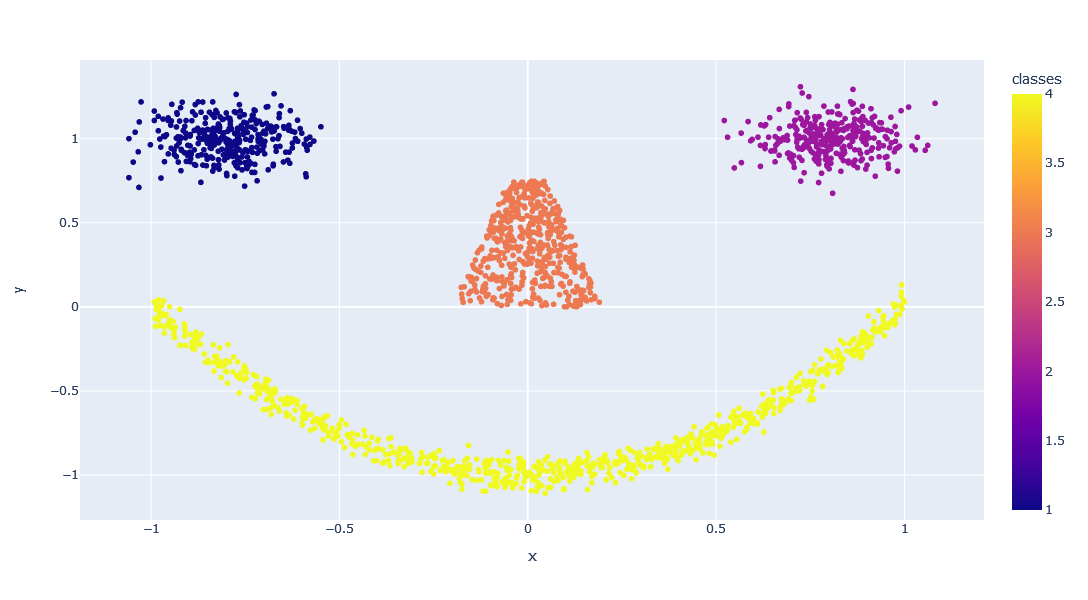

In [334]:
fig = px.scatter(smiley, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [335]:
# Sampling from each individual column then append together
# Function: can take categorical input sampling when it is NOT one-hot encoded
def sampling(data, n, random_state):
    synth_data = pd.DataFrame()
    i = 0
    # sample column by column
    # pseudo-random
    for column in data.columns:
        synth_data[column] = data[column].sample(n = n, replace = True, random_state = random_state + i * 10).reset_index(drop = True)
        i += 1
    return synth_data

In [336]:
synth_smiley = sampling(smiley, 2000, 111)

In [337]:
# encode features, run once only
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
smiley_targets_enc = enc.fit_transform(smiley[['classes']])
enc = OneHotEncoder(sparse = False)
synths_targets_enc = enc.fit_transform(synth_smiley[['classes']])

Feasibly can adapt to any dataset, but need a way to read in categorical variables
 - Specify columns that are categorical

In [338]:
smiley[['0', '1', '2', '3']] = smiley_targets_enc
smiley.drop(['classes'], axis = 1, inplace = True)
synth_smiley[['0', '1', '2', '3']] = synths_targets_enc
synth_smiley.drop(['classes'], axis = 1, inplace = True)

In [339]:
smiley['label'] = 1
synth_smiley['label'] = 0
X = pd.concat((smiley, synth_smiley))
X = X.reset_index().drop('index', axis = 1)

In [340]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [341]:
import xgboost as xgb

In [342]:
model = xgb.XGBClassifier(random_state = 1, n_estimators = 50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [391]:
preds = model.predict(X_test)
np.sum(preds == y_test)/len(y_test)
model.score(X_test, y_test)

0.9383333333333334

In [344]:
booster = model.get_booster()

In [345]:
#get all real datapoints
indices = y_train[y_train == 1].index
real_df = X_train.loc[indices].reset_index().drop('index', axis = 1)

In [346]:
leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
contribs = booster.predict(xgb.DMatrix(real_df), pred_contribs = True, strict_shape = True)

In [347]:
booster.dump_model('xgb_model.txt', with_stats = True)

In [348]:
# get df of trees information
tree_df = booster.trees_to_dataframe()

In [349]:
# split into each idv tree
trees_grouped = tree_df.groupby('Tree')
trees = [trees_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in trees_grouped.groups]

In [350]:
upper_bounds = []
lower_bounds = []

In [351]:
#get bounds for all leaves of all trees
columns = ['x', 'y', '0', '1', '2', '3']
for tree in trees:
    size = len(tree)
    upper_df = pd.DataFrame(np.ones((size, 6)) * np.inf, columns = columns)
    lower_df = pd.DataFrame(np.ones((size, 6)) * -np.inf, columns = columns)
    non_leaves = []
    for index, row in tree.iterrows():
        left_child = row['Yes']
        right_child = row['No']
        feature = row['Feature']
        split = row['Split']
        parent = int(row['Node'])
        if feature != 'Leaf':
            parent_lower = lower_df.loc[parent]
            parent_upper = upper_df.loc[parent]
            left_child = int(left_child.split('-')[1])
            right_child = int(right_child.split('-')[1])
            lower_df.loc[left_child] = parent_lower
            lower_df.loc[right_child] = parent_lower
            upper_df.loc[left_child] = parent_upper
            upper_df.loc[right_child] = parent_upper
            upper_df.loc[left_child, feature] = split
            lower_df.loc[right_child, feature] = split
            non_leaves.append(parent)
    upper_df = upper_df.drop(non_leaves)
    lower_df = lower_df.drop(non_leaves)
    upper_bounds.append(upper_df)
    lower_bounds.append(lower_df)

In [352]:
leaves_df = pd.DataFrame(leaves)

In [353]:
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance

In [354]:
clustering = AgglomerativeClustering(n_clusters = None, affinity = 'hamming', linkage = 'average', distance_threshold = 0.1)
clustering.fit(leaves)

AgglomerativeClustering(affinity='hamming', distance_threshold=0.1,
                        linkage='average', n_clusters=None)

In [355]:
leaves_df['cluster'] = clustering.labels_

In [356]:
counts = leaves_df.groupby('cluster').count()[0]
valid_clusters = counts[counts > 6].index
clusters = []
coverage = []
for cluster_id in valid_clusters:
    cluster = leaves_df[leaves_df['cluster'] == cluster_id]
    cluster_size = len(cluster)
    cluster_centroid = cluster.mode().iloc[0]
    clusters.append(cluster_centroid)
    coverage.append(cluster_size)

In [357]:
len(clusters)

57

In [358]:
upper_cluster_bounds = []
lower_cluster_bounds = []
for i in range(0, len(clusters)):
    uppers = []
    lowers = []
    for j in range(0, len(upper_bounds)):
        uppers.append(upper_bounds[j].loc[clusters[i][j]])
        lowers.append(lower_bounds[j].loc[clusters[i][j]])
    upper_cluster_bounds.append(pd.DataFrame(uppers).min(axis = 0))
    lower_cluster_bounds.append(pd.DataFrame(lowers).max(axis = 0))
upper_cluster_bounds = pd.DataFrame(upper_cluster_bounds)
lower_cluster_bounds = pd.DataFrame(lower_cluster_bounds)

In [359]:
upper_cluster_bounds.columns = upper_cluster_bounds.columns + ' upper'
lower_cluster_bounds.columns = lower_cluster_bounds.columns + ' lower'

In [360]:
final_bounds = pd.concat([upper_cluster_bounds, lower_cluster_bounds], axis = 1)

In [361]:
n = sum(coverage)
fractions = [coverage[i]/n for i in range(0, len(coverage))]

In [362]:
sample = final_bounds.sample(2000, weights = fractions, replace = True)

In [363]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == np.inf and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == np.inf and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == np.inf and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

/tmp/ipykernel_99/3648666551.py:4: RuntimeWarning:

invalid value encountered in double_scalars



In [364]:
gen

,x,y,classes
0,-0.819397,-0.338212,3
1,-0.059767,-0.905338,3
2,-0.080017,NaN,3
3,-0.010245,-0.987855,3
4,-0.007699,0.447674,2
...,...,...,...
1995,0.858217,-0.235372,3
1996,-0.803242,1.112233,0
1997,-0.574650,-0.724992,3
1998,0.774502,1.003110,1


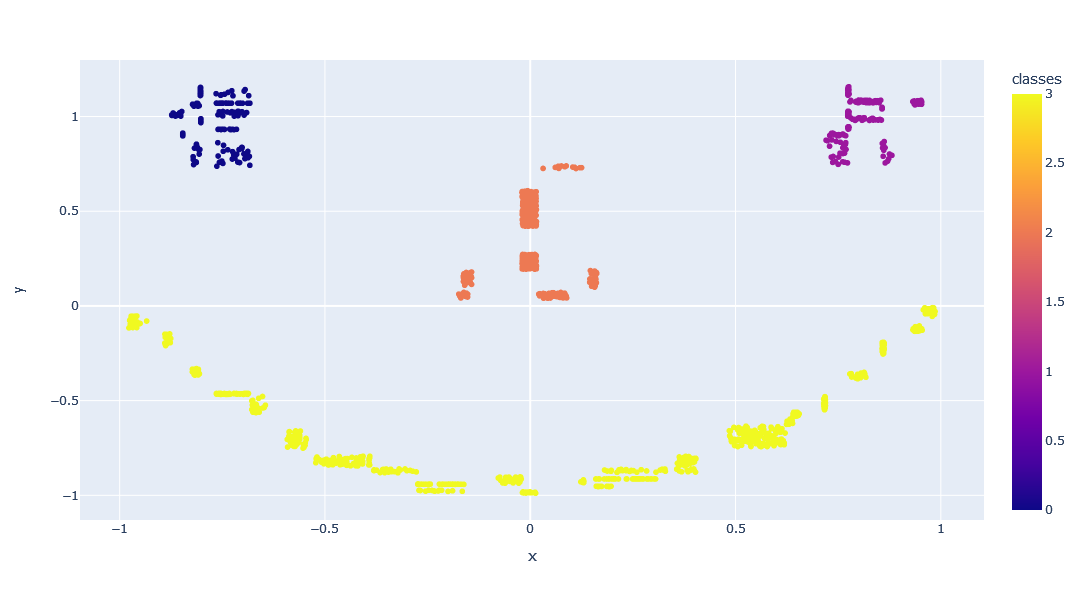

In [365]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

## Density Estimation with clusters

In [366]:
real_df

,x,y,0,1,2,3
0,-0.836145,0.807116,1.0,0.0,0.0,0.0
1,-0.941679,-0.086698,0.0,0.0,0.0,1.0
2,0.709411,1.110365,0.0,1.0,0.0,0.0
3,-0.966649,0.035358,0.0,0.0,0.0,1.0
4,0.101098,0.086843,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1426,-0.749943,0.933628,1.0,0.0,0.0,0.0
1427,-0.064748,0.675677,0.0,0.0,1.0,0.0
1428,-0.698480,0.909858,1.0,0.0,0.0,0.0
1429,-0.560815,-0.669808,0.0,0.0,0.0,1.0


In [367]:
cluster_df = real_df
cluster_df['clusters'] = clustering.labels_
cluster_df = cluster_df[cluster_df['clusters'].isin(valid_clusters)]
cluster_grouped = cluster_df.groupby('clusters')
cluster_dfs = [cluster_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in cluster_grouped.groups]

In [368]:
from sklearn.neighbors import KernelDensity

In [369]:
densities = []
multinomial = [[] for i in range(len(valid_clusters))]
for i in range(0, len(cluster_dfs)):
    densities.append(KernelDensity(kernel = 'gaussian', bandwidth = 0.05).fit(cluster_dfs[i].iloc[:, :2]))
    cluster_size = len(cluster_dfs[i])
    for j in range(0, 4):
        # laplacian estimation
        multinomial[i].append((sum(cluster_dfs[i].iloc[:, 2 + j]) + 1)/(cluster_size + 4))

In [370]:
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    cluster_index = np.random.choice(len(valid_clusters), p = fractions)
    sampler = densities[cluster_index]
    class_label = np.random.choice(class_size, p = multinomial[cluster_index])
    samples.append(sampler.sample())
    samples_class.append(class_label)
len(samples)

2000

In [371]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

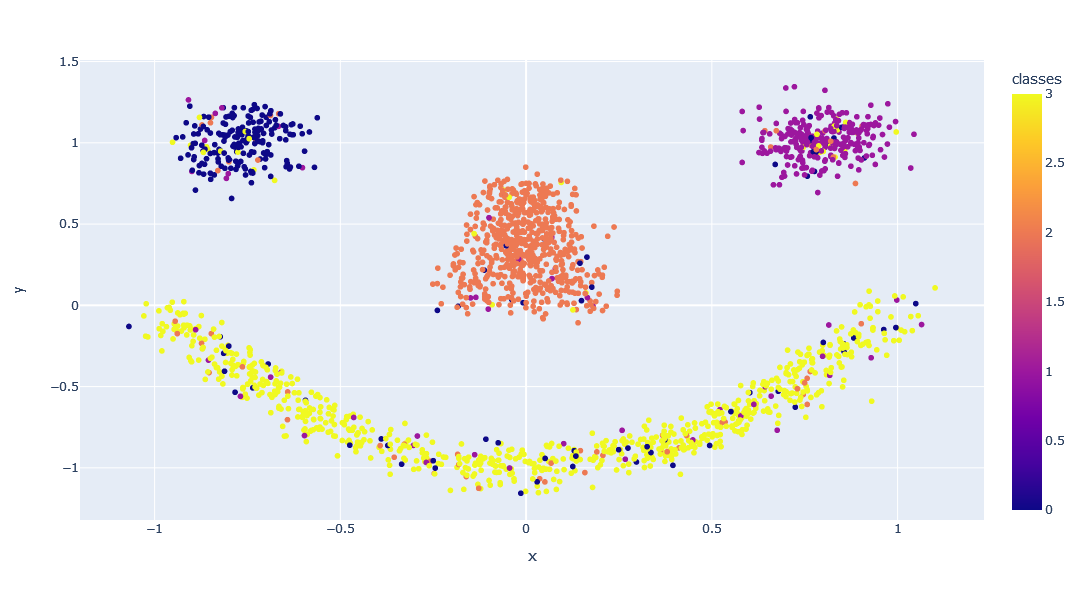

In [372]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

## Uniform Box Sampling with Bound Expansion

In [373]:
leaves_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,32.0,30.0,35.0,33.0,35.0,35.0,35.0,36.0,27.0,32.0,...,25.0,29.0,25.0,19.0,11.0,26.0,19.0,37.0,31.0,111
1,31.0,27.0,32.0,23.0,42.0,42.0,42.0,41.0,25.0,33.0,...,25.0,27.0,25.0,19.0,21.0,26.0,19.0,37.0,27.0,51
2,40.0,30.0,42.0,36.0,40.0,40.0,40.0,38.0,29.0,38.0,...,26.0,34.0,33.0,21.0,26.0,26.0,12.0,34.0,37.0,151
3,31.0,31.0,32.0,23.0,42.0,31.0,42.0,41.0,25.0,33.0,...,25.0,27.0,25.0,19.0,23.0,26.0,19.0,37.0,27.0,82
4,31.0,34.0,38.0,37.0,36.0,36.0,36.0,38.0,28.0,32.0,...,25.0,27.0,25.0,19.0,26.0,26.0,19.0,37.0,27.0,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,34.0,30.0,35.0,33.0,35.0,35.0,35.0,36.0,28.0,32.0,...,25.0,34.0,25.0,19.0,26.0,26.0,19.0,37.0,37.0,117
1427,31.0,34.0,34.0,37.0,36.0,36.0,36.0,38.0,28.0,32.0,...,25.0,30.0,25.0,19.0,26.0,26.0,19.0,37.0,32.0,69
1428,34.0,30.0,35.0,33.0,35.0,35.0,35.0,36.0,28.0,32.0,...,25.0,33.0,25.0,19.0,26.0,26.0,19.0,37.0,35.0,170
1429,31.0,28.0,33.0,33.0,43.0,44.0,42.0,31.0,28.0,33.0,...,23.0,27.0,25.0,19.0,26.0,26.0,19.0,35.0,27.0,169


In [374]:
leaves_df = leaves_df[leaves_df['cluster'].isin(valid_clusters)]
leaves_grouped = leaves_df.groupby('cluster')
leaves_dfs = [leaves_grouped.get_group(x).reset_index().drop('index', axis = 1).drop_duplicates() for x in leaves_grouped.groups]

In [375]:
upper_box_df = []
lower_box_df = []
for i in range(0, len(leaves_dfs)):
    upper_box = []
    lower_box = []
    working_df = leaves_dfs[i]
    for index, row in working_df.iterrows():
        uppers = []
        lowers = []
        for k in range(0, len(upper_bounds)):
            leaf_value = row[k]
            uppers.append(upper_bounds[k].loc[leaf_value])
            lowers.append(lower_bounds[k].loc[leaf_value])
        upper_box.append(pd.DataFrame(uppers).min(axis = 0))
        lower_box.append(pd.DataFrame(lowers).max(axis = 0))
    upper_box_df.append(pd.DataFrame(upper_box).max(axis = 0))
    lower_box_df.append(pd.DataFrame(lower_box).min(axis = 0))
upper_box_df = pd.DataFrame(upper_box_df)
lower_box_df = pd.DataFrame(lower_box_df)

In [376]:
upper_box_df.columns = upper_box_df.columns + ' upper'
lower_box_df.columns = lower_box_df.columns + ' lower'

In [377]:
final_box = pd.concat([upper_box_df, lower_box_df], axis = 1)

In [378]:
n = sum(coverage)
fractions = [coverage[i]/n for i in range(0, len(coverage))]

In [379]:
sample = final_box.sample(2000, weights = fractions, replace = True)

In [380]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == np.inf and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == np.inf and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == np.inf and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

/tmp/ipykernel_99/3648666551.py:4: RuntimeWarning:

invalid value encountered in double_scalars



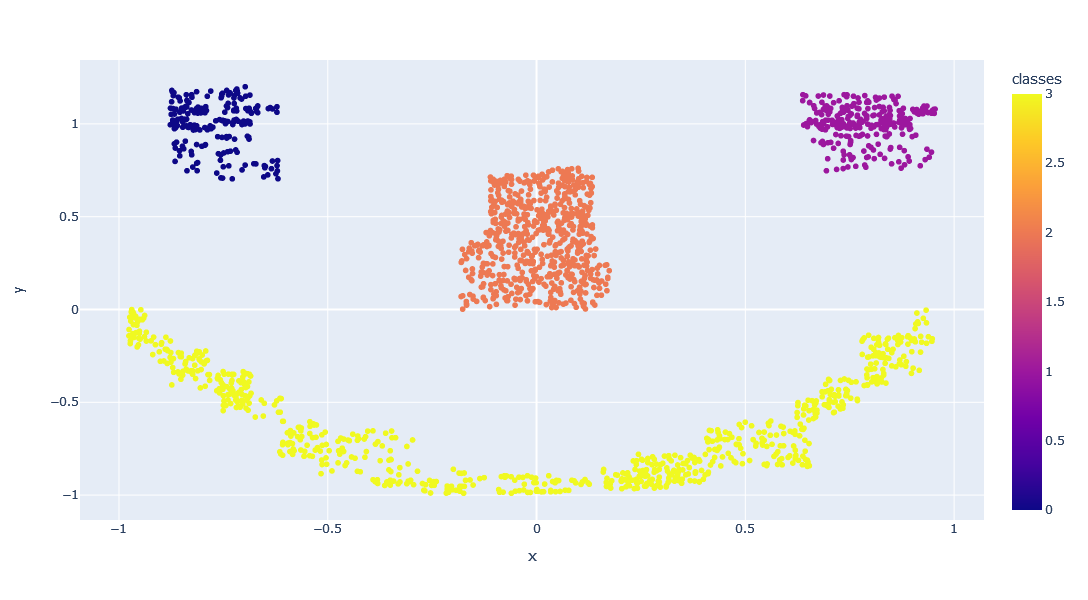

In [381]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [382]:
final_box.head()

,x upper,y upper,0 upper,1 upper,2 upper,3 upper,x lower,y lower,0 lower,1 lower,2 lower,3 lower
0,0.955022,-0.002454,0.5,0.5,0.5,inf,0.902332,-0.186299,-inf,-inf,-inf,0.5
1,0.922325,0.946288,0.5,inf,0.5,0.5,0.714703,0.930685,-inf,0.5,-inf,-inf
2,-0.774441,0.995497,inf,0.5,0.5,0.5,-0.878682,0.965872,0.5,-inf,-inf,-inf
3,0.177869,0.271856,0.5,0.5,inf,0.5,0.144463,0.000765,-inf,-inf,0.5,-inf
4,-0.780060,-0.222416,0.5,0.5,0.5,inf,-0.873639,-0.432803,-inf,-inf,-inf,0.5


In [383]:
final_bounds.head()

,x upper,y upper,0 upper,1 upper,2 upper,3 upper,x lower,y lower,0 lower,1 lower,2 lower,3 lower
0,0.955022,-0.103477,0.5,0.5,0.5,inf,0.931593,-0.135226,-inf,-inf,-inf,0.5
1,0.773216,0.946288,0.5,inf,0.5,0.5,0.776475,0.933692,-inf,0.5,-inf,-inf
2,-0.802214,0.988676,inf,0.5,0.5,0.5,-0.802214,0.965872,0.5,-inf,-inf,-inf
3,0.163178,0.191690,0.5,0.5,inf,0.5,0.144463,0.093960,-inf,-inf,0.5,-inf
4,-0.803922,-0.328219,0.5,0.5,0.5,inf,-0.823708,-0.368776,-inf,-inf,-inf,0.5


## MLE with clusters

In [384]:
np.array(cluster_dfs[17].iloc[:, :2].min())

array([-0.86733294,  1.11431057])

In [385]:
from scipy.stats import multivariate_normal

In [386]:
mean = []
cov = []
min_value = []
max_value = []
multinomial = [[] for i in range(len(valid_clusters))]
for i in range(0, len(cluster_dfs)):
    working_df = cluster_dfs[i]
    mean.append(working_df.iloc[:, :2].mean())
    cov.append(working_df.iloc[:, :2].cov())
    min_value.append(working_df.iloc[:, :2].min())
    max_value.append(working_df.iloc[:, :2].max())
    cluster_size = len(cluster_dfs[i])
    for j in range(0, 4):
        # laplacian estimation
        multinomial[i].append((sum(cluster_dfs[i].iloc[:, 2 + j]) + 0.1)/(cluster_size + 0.4))

In [387]:
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    cluster_index = np.random.choice(len(valid_clusters), p = fractions)
    sample_mean = mean[cluster_index]
    sample_cov = cov[cluster_index]
    # rejection sampling
    sample_min = min_value[cluster_index]
    sample_max = max_value[cluster_index]
    class_label = np.random.choice(class_size, p = multinomial[cluster_index])
    k = multivariate_normal.pdf(x = sample_mean, mean = sample_mean, cov = sample_cov)
    x = np.random.uniform(low = sample_min, high = sample_max, size = (1, 2))
    y = np.random.uniform(low = 0, high = k, size = 1)
    while y > multivariate_normal.pdf(x = x, mean = sample_mean, cov = sample_cov):
        x = np.random.uniform(low = sample_min, high = sample_max, size = (1, 2))
        y = np.random.uniform(low = 0, high = k, size = 1)
    samples.append(x)
    samples_class.append(class_label)
len(samples)

2000

In [388]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

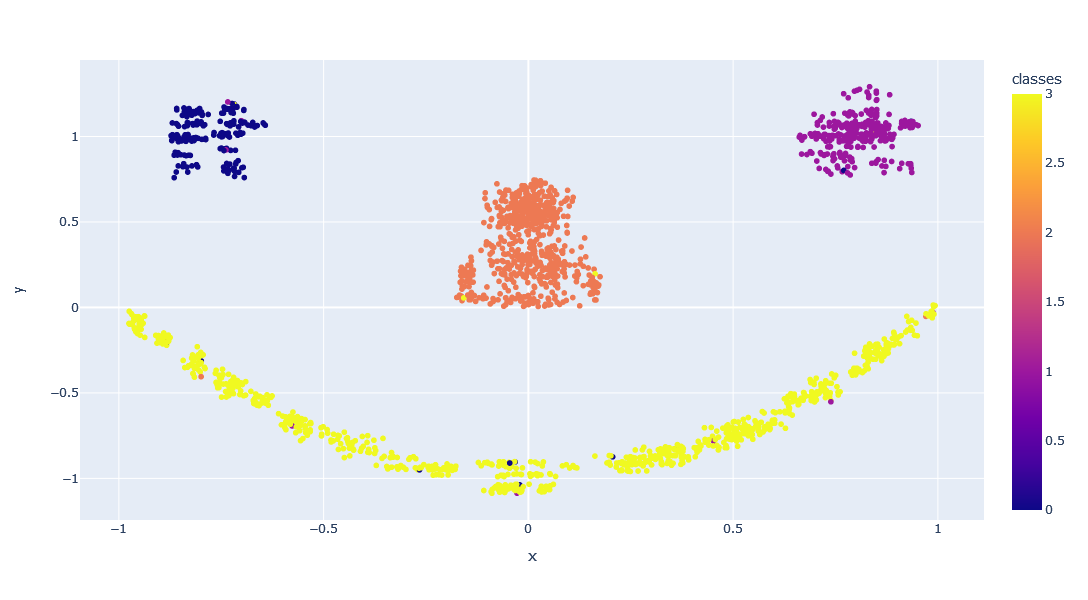

In [389]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig